# Navigation

---

## 1. Introduction

In this notebook, we solve a prebuilt Reacher environment from the [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) engine using a vanilla version of the `Deep Deterministic Policy Gradients` (DDPG) algorithm.

In [1]:
# Imports
from unityagents import UnityEnvironment
import numpy as np
from DDPG import *

## 2. Description of the environment and example run

The simulation contains a single agent, a robot armed with a single two-jointed arm. Around the agent, a spheric volume moves and shifts positions, while the goal of the agent is to keep the end of the arm inside of the volume at any given timestep. The environment is better described as follows:

- **State space**: The state space dimension `33`, where the dimension corresponds to sensory input including position, rotation, velocity, and angular velocities of the arm. 
- **Action space**: Each action is a vector with `4` numbers, corresponding to torque applicable to two joints. Every entry in the action vector should be a number between -1 and 1.
- **Rewards**: A reward of `+0.1` is provided for each step that the agent's hand is in the goal location.


---

### 2.1. Exploring the environment

We explore the environment in the code below

In [2]:
##########################
#### THE ENVIRONMENT #####
##########################

# Initialize the environment
env = UnityEnvironment(file_name="Reacher_Windows_x86_64//Reacher.x86_64")

# Unity environment agents are represented by brains. In this environment we only have one brain, the robotic arm to be trained
print('Number of agents in the environment:', len(env.brain_names))
brain_name = env.brain_names[0]
brain = env.brains[brain_name]



##########################
#### THE STATE SPACE #####
##########################

env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations[0]
print('Total dimensions in state:', len(state))
print('States look like:', state)



######################
## THE ACTION SPACE ##
######################

print('Action space dimension:', brain.vector_action_space_size)


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents in the environment: 1
Total dimensions in state: 33
States look like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]
Action space dimension: 4


### 2.2. Example run

Let's see how a random agent would perform

In [3]:
# Reset the environment, assign the initial state and initialize the score
env_info = env.reset(train_mode=False)[brain_name] 
state = env_info.vector_observations[0]            
score = 0                                          

# Play the environment
while True:
    
    # Select an action at random and send it to the environment
    action = np.random.normal(0,1,4).clip(-1,1)   
    env_info = env.step(action)[brain_name]        
    
    # Collect the next state and the reward
    next_state = env_info.vector_observations[0]   
    reward = env_info.rewards[0]                   
    score += reward
    
    # Move onto the next state and exit if it's terminal
    done = env_info.local_done[0]                  
    state = next_state                             
    if done: break
    
print("Final score: {}".format(score))
env.close()


Final score: 0.40999999083578587


## 3. Training an agent (restart the kernel before running)

Initialize the agent and the environment:

In [1]:
# Imports
from unityagents import UnityEnvironment
import numpy as np
from DDPG import *
from collections import deque
import torch
import matplotlib.pyplot as plt

# Initialize the environment and assign the brain
env = UnityEnvironment(file_name="Reacher_Windows_x86_64//Reacher.x86_64")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Reset environment and assign initial state
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations[0]

# Start an agent
agent = Agent(state_size = len(state), 
              action_size = brain.vector_action_space_size, 
              seed = 42)


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Main algorithm

In [2]:
def ddpg(n_episodes=5000, 
         eps_start=0.6, 
         eps_end=0.0005, 
         eps_decay=0.98):
    
    ''' Train a Deep Deterministic Policy Gradient agent to solve the environment '''
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    # For each one of the training episodes
    for i_episode in range(1, n_episodes+1):
        
        # Restart the environment and the score
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        
        # Play the episode
        done = False
        while not done:
            
            # Have the agent pick an epsilon-greedy action wrt its current policy (i.e. exploration defined as a noise term)
            action = agent.act(state, eps)
            
            # Take the action and store environment output
            env_info = env.step(action.data.numpy())[brain_name]
            next_state = env_info.vector_observations[0]   
            reward = env_info.rewards[0]    
            done = env_info.local_done[0]  
            
            # Update agent's knowledge
            agent.step(state, action, reward, next_state, done)
            
            # Set new state as current and update the agent's score
            score += reward   
            state = next_state
            
        # When the episode is done, save scores into our lists, and decrease the epsilon for the next episode
        scores_window.append(score)       
        scores.append(score)              
        eps = max(eps_end, eps_decay*eps)
        if i_episode % 20 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
        # When the agent is trained, we save the weights of the Q-network and exit the routine
        if np.mean(scores_window)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            break
            
    torch.save(agent.actor_local.state_dict(), 'trained_agent.pth')
            
    return scores


Execution of the algorihtm

Episode 20	Average Score: 0.24
Episode 40	Average Score: 0.81
Episode 60	Average Score: 1.03
Episode 80	Average Score: 1.46
Episode 100	Average Score: 3.15
Episode 120	Average Score: 6.25
Episode 140	Average Score: 11.29
Episode 160	Average Score: 17.28
Episode 180	Average Score: 23.04
Episode 200	Average Score: 27.88

Environment solved in 111 episodes!	Average Score: 30.08


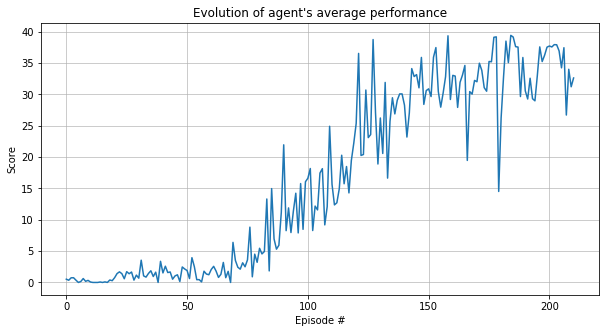

In [3]:
scores = ddpg()

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title("Evolution of agent's average performance")
plt.grid(alpha=0.8)
plt.show()

## 4. Our agent in action! (restart the kernel before running)

We leverage the network weights learned in section 3 to create an intelligent agent, and watch it interact with its environment.

In [1]:
# Imports
from unityagents import UnityEnvironment
import numpy as np
from DDPG import *
from collections import deque
import torch

# Initialize the environment and assign the brain
env = UnityEnvironment(file_name="Reacher_Windows_x86_64//Reacher.x86_64")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Reset the environment, assign the initial state and initialize the score
for i in range(5): env_info = env.reset(train_mode=False)[brain_name] 
state = env_info.vector_observations[0]            
score = 0       

# Start an agent and assign it the trained network
agent = Agent(state_size = len(state), 
              action_size = brain.vector_action_space_size, 
              seed = 42)

agent.actor_local.load_state_dict(torch.load('trained_agent.pth'))

                 
# Play the environment
while True:
    
    # Have the agent pick a greedy action wrt its current policy
    action = agent.act(state, 0)

    # Take the action and store environment output
    env_info = env.step(action.data.numpy())[brain_name]
    next_state = env_info.vector_observations[0]   
    reward = env_info.rewards[0]  
    score += reward

    # Move onto the next state and exit if it's terminal
    done = env_info.local_done[0]                  
    state = next_state                             
    if done: break
    
print("Final score: {}".format(score))
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Final score: 37.469999162480235
